# T-test

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

In this notebook we demo how to perform a two-sample Bayesian t-test to compare the mean value of two Gaussian populations using Bambi.

## Generate data

We generate 160 values from a Gaussian with $\mu=6$ and $\sigma=2.5$ and another 120 values from a Gaussian'
with $\mu=8$ and $\sigma=2$

In [3]:
a = np.random.normal(6, 2.5, 160)
b = np.random.normal(8, 2, 120)
df = pd.DataFrame({"Group": ["a"] * 160 + ["b"] * 120, "Val": np.hstack([a, b])})

In [4]:
df.head()

,Group,Val
0,a,7.178588
1,a,3.022561
2,a,9.581767
3,a,5.218370
4,a,4.198528


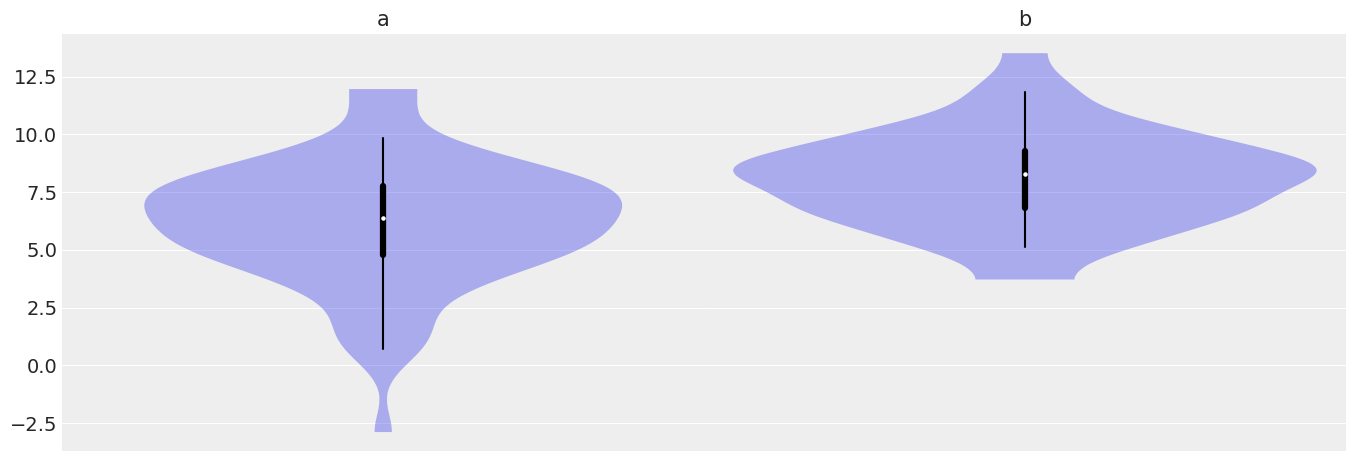

In [5]:
az.plot_violin({"a": a, "b": b});

### Model

When we carry out a two sample t-test we're implicitly using the following model:

$$
\mu_i = \beta_0 + \beta_1 (i) + \epsilon_i
$$

where $i = 0$ represents the population 1, $i = 1$ the population 2 and $\epsilon_i$ is a random error with mean 0. If we replace the indicator variables for the two groups we have 

$$
\mu_0 = \beta_0 + \epsilon_i
$$

and

$$
\mu_1 = \beta_0 + \beta_1 + \epsilon_i
$$

if $\mu_0 = \mu_1$ then

$$
\beta_0 + \epsilon_i = \beta_0 + \beta_1 + \epsilon_i\\
0 = \beta_1
$$

Thus, we can see that testing whether the mean of the two populations are equal is equivalent to testing whether $\beta_1$ is 0.

### Analysis

We start by instantiating our model and specifying the model previously described.

In [6]:
model = bmb.Model("Val ~ 0 + Group", df)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Val_sigma, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We've only specified the formula for the model and Bambi automatically selected priors distributions and values for their parameters. We can inspect both the setup and the priors as following:

In [7]:
model

Formula: Val ~ 0 + Group
Family name: Gaussian
Link: identity
Observations: 280
Priors:
  Group ~ Normal(mu: 6.97615653, sigma: 2.46108055)
  sigma ~ HalfStudentT(nu: 4, sigma: 2.45668183)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

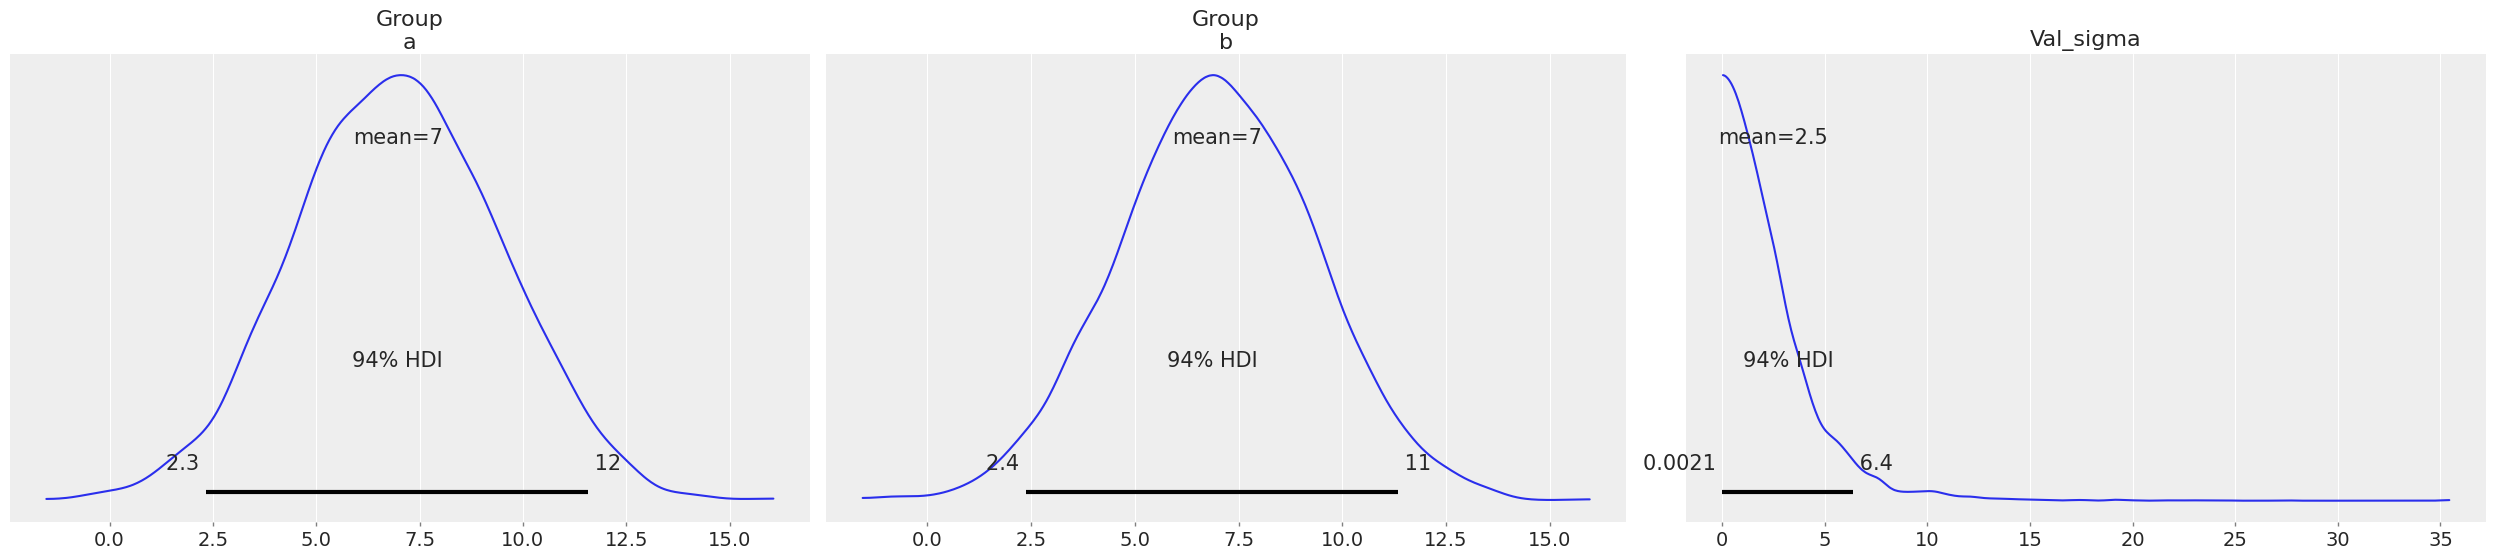

In [8]:
model.plot_priors();

To inspect our posterior and the sampling process we can call `az.plot_trace()`. The option `kind='rank_vlines'` gives us a variant of the rank plot that uses lines and dots and helps us to inspect the stationarity of the chains. Since there is no clear pattern or serious deviations from the horizontal lines, we can conclude the chains are stationary.

<!-- I think the reasoning is too simplistic but I don't know if we should make it more complicated here -->

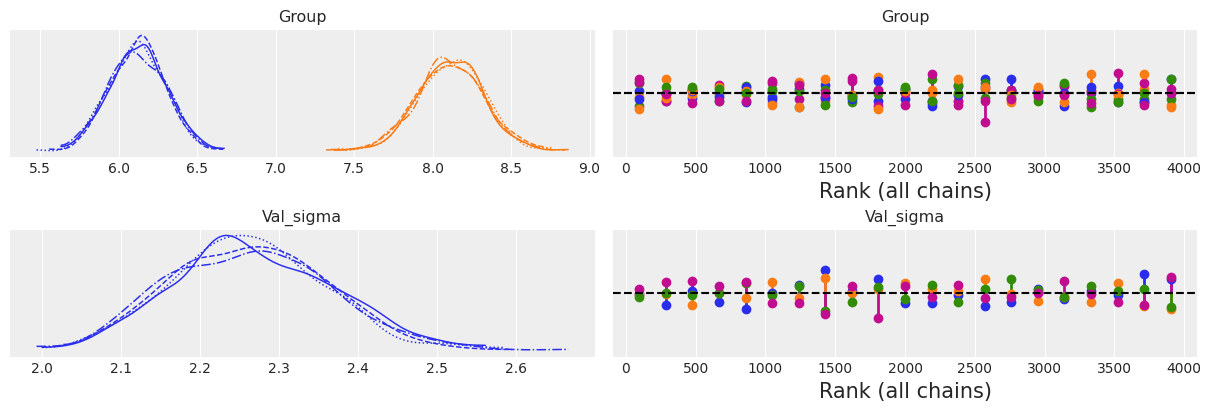

In [9]:
az.plot_trace(results, kind="rank_vlines");

In [10]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Group[a],6.120,0.177,5.790,6.449,0.002,0.002,5103.0,2934.0,1.0
Group[b],8.115,0.210,7.721,8.506,0.003,0.002,5714.0,3084.0,1.0
Val_sigma,2.264,0.100,2.077,2.440,0.001,0.001,5335.0,3124.0,1.0


In the summary table we can see the 94% highest density interval for $\beta_1$ ranges from 1.201 to 2.173. Thus, according to the data and the model used, we conclude the difference between the two population means is somewhere between 1.2 and 2.2 and hence we support the hypotehsis that $\beta_1 \ne 0$.

Similar conclusions can be made with the density estimate for the posterior distribution of $\beta_1$. As seen in the table, most of the probability for the difference in the mean roughly ranges from 1.2 to 2.2.

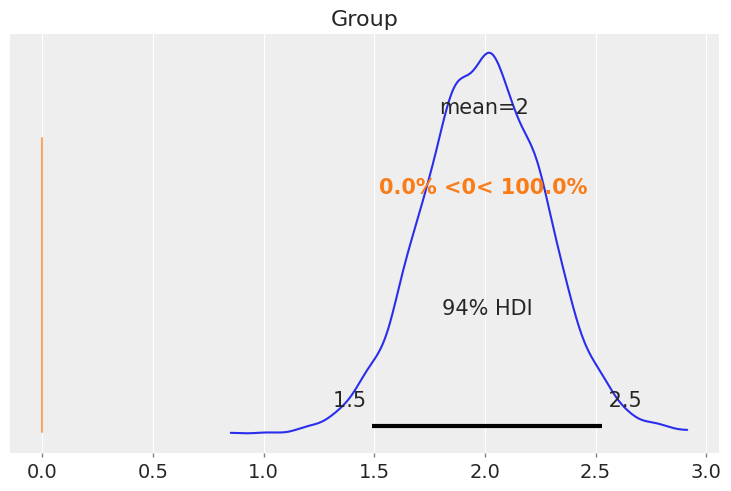

In [11]:
# Grab just the posterior of the term of interest (group)
group_posterior = results.posterior['Group'][:,:,1]-results.posterior['Group'][:,:,0]
az.plot_posterior(group_posterior, ref_val=0);

Another way to arrive to a similar conclusion is by calculating the probability that the parameter $\beta_1 > 0$. This probability, practically equal to 1, tells us that the mean of the two populations are different.

In [12]:
# Probabiliy that posterior is > 0
(group_posterior.values > 0).mean()

1.0

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 14 2021

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.22.0

bambi     : 0.4.1
numpy     : 1.20.1
pandas    : 1.2.4
arviz     : 0.11.2
matplotlib: 3.4.2

Watermark: 2.2.0

